<a href="https://colab.research.google.com/github/sv9-ru/flow_meter/blob/main/%D1%81%D1%80%D0%B0%D0%B2%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Начало работы

## Библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # библиотека для построения графиков
from sklearn.model_selection import train_test_split # функция для разделения данных на обучающую и тестовую выборки
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import KDTree # структура данных для быстрого поиска ближайших соседей
from IPython.display import display # улучшенный вывод объектов в Jupyter/Colab


## Выгрузка и подготовка данных

In [2]:
url = "https://cmfdata.susu.ru/uploads/5~1580896402-card/dataset1_full.xlsx"
df = pd.read_excel(url, sheet_name='AllData', skiprows=3)
df.dropna(axis=1, how='all', inplace=True)
df.dropna(axis=0, how='all', inplace=True)
df.reset_index(drop=True, inplace=True)

df.columns = [
    'Nominal Mass Flow [kg/s]',     # Номинальный (заданный) массовый расход
    'Ref Mass Flow [kg/s]',         # Эталонный массовый расход (измерен независимо, "истина")
    'Ref Density [kg/m3]',          # Эталонная плотность
    'GVF [%]',                      # Газосодержание по объёму, % (Gas Volume Fraction)
    'Cor Mass Flow [kg/s]',         # Измеренный кориолисом массовый расход (с ошибкой при GVF > 0)
    'Cor Density [kg/m3]',          # Измеренная плотность (тоже падает при газе)
    'Cor Density Drop [%]',         # Падение плотности относительно однофазного режима, %
    'Err Mass Flow [%]',            # Ошибка массового расхода: (Cor - Ref)/Ref * 100%
    'Err Density [%]',              # Ошибка плотности: (Cor_dens - Ref_dens)/Ref_dens * 100%
    'Err Density Drop [%]'          # Ошибка в оценке падения плотности
]

df

,Nominal Mass Flow [kg/s],Ref Mass Flow [kg/s],Ref Density [kg/m3],GVF [%],Cor Mass Flow [kg/s],Cor Density [kg/m3],Cor Density Drop [%],Err Mass Flow [%],Err Density [%],Err Density Drop [%]
0,0.400000,0.388189,881.985773,0.000000,0.382319,882.351249,-0.041438,-1.512080,0.041438,0.041438
1,0.400000,0.394546,864.927467,1.937404,0.372571,870.716319,1.272146,-5.569839,0.669288,0.661934
2,0.400000,0.395661,839.054391,4.878619,0.374177,853.636886,3.202944,-5.429938,1.737968,1.664638
3,0.400000,0.384471,793.836315,10.024014,0.349452,826.056071,6.324710,-9.108449,4.058741,3.669721
4,0.400000,0.380295,750.509635,14.956647,0.332518,801.325179,9.124674,-12.563232,6.770805,5.782158
...,...,...,...,...,...,...,...,...,...,...
98,3.198919,3.198517,787.076997,10.718202,3.133618,780.669167,11.405913,-2.029058,-0.814130,-0.645108
99,3.198919,3.203326,741.856139,15.870485,3.115105,740.097075,16.011433,-2.754035,-0.237117,-0.123463
100,3.198919,3.206674,697.252279,20.954153,3.104561,700.877401,20.464128,-3.184391,0.519915,0.481051
101,3.198919,3.210449,655.637726,25.698116,3.052219,664.833119,24.556245,-4.928577,1.402511,1.107213


# Цель модели: Коррекция ошибок Кориолисового расходомера при двухфазном потоке

---

> **Проблема**:  
> Кориолисовые расходомеры **теряют точность** при наличии газа в жидкости (**GVF > 0%**).  
> → Измеренный массовый расход (`Cor Mass Flow`) и плотность (`Cor Density`) **завышены**.

---

## Что мы ищем?

| Задача                          | Формула                                                                 |
|---------|-----|
| **Предсказать ошибку массового расхода** | $ m_{\mathrm{err}} = \frac{m_{\mathrm{obs}} - m_{\mathrm{true}}}{m_{\mathrm{true}}} \cdot 100\% $ |
| **Предсказать ошибку плотности**         | $ \rho_{\mathrm{err}} = \frac{\rho_{\mathrm{obs}} - \rho_{\mathrm{true}}}{\rho_{\mathrm{true}}} \cdot 100\% $ |
| **Исправить измерения**                  | $ m_{\mathrm{corr}} = \frac{m_{\mathrm{obs}}}{1 + \frac{m_{\mathrm{err}}}{100}} $ |


| Мы ищем | Как | Зачем |
|---------|-----|-------|
| **Функцию f(m_obs, dd) → err%** | `pred_err = model(m_obs, dd)` | Чтобы знать, на сколько % ошибается расходомер |
| **Исправленное значение** | `m_corr = m_obs / (1 + pred_err/100)` | Чтобы выдать точный расход в реальном времени |
---

## Входные данные

| Признак | Физический смысл |
|--------|------------------|
| `Cor Mass Flow [kg/s]` | Измеренный расход (с ошибкой) |
| `Cor Density Drop [%]` |$ ( dd = \frac{\rho_l - \rho_{obs}}{\rho_l} \times 100\% )$ → индикатор GVF |

> **GVF ≈ dd** при $(\rho_g \ll \rho_l)$

# ВЫХОДНЫЕ ДАННЫЕ (Targets)

| Переменная | Название | Единицы |
|------------|-----------|------|
| **Err Mass Flow [%]** | `m_err` | % |
| **Err Density [%]** | `ρ_err` | % |

---

## Цель модели

> **На основе `m_obs` и `dd` предсказать `m_err` и `ρ_err` → скорректировать показания расходомера в реальном времени.**

---

## Как это работает?

```python
# 1. Предсказание ошибки
pred_err = model.predict([m_obs, dd])

# 2. Коррекция
m_corrected = m_obs / (1 + pred_err / 100)

In [3]:
X = df[['Cor Mass Flow [kg/s]', 'Cor Density Drop [%]']].values
y_mf = df['Err Mass Flow [%]'].values # y_mf — целевая переменная №1: ошибка массового расхода в %
y_rho = df['Err Density [%]'].values # y_rho — целевая переменная №2: ошибка плотности в %

# Эти массивы нужны ПОСЛЕ предсказания, чтобы:
#   1. Применить коррекцию
#   2. Посчитать % улучшения точности
#   3. Сравнить с эталоном

m_obs = df['Cor Mass Flow [kg/s]'].values      # измерено расходомером (с ошибкой)
m_true = df['Ref Mass Flow [kg/s]'].values     # эталонное (истинное) значение
rho_obs = df['Cor Density [kg/m3]'].values     # измеренная плотность
rho_true = df['Ref Density [kg/m3]'].values    # эталонная плотность

# РАЗДЕЛЕНИЕ НА ОБУЧАЮЩУЮ И ТЕСТОВУЮ ВЫБОРКИ
X_train, X_test, y_mf_train, y_mf_test, y_rho_train, y_rho_test, \
m_obs_train, m_obs_test, m_true_train, m_true_test, \
rho_obs_train, rho_obs_test, rho_true_train, rho_true_test = train_test_split(
    X, y_mf, y_rho, m_obs, m_true, rho_obs, rho_true,
    test_size=0.2, random_state=42
)
# нормализация данных
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

# results_summary — список словарей
# Будем сохранять: модель, целевая переменная, метрики, % улучшения
# Потом → pd.DataFrame → таблица сравнения
results_summary = []

## Построение графиков

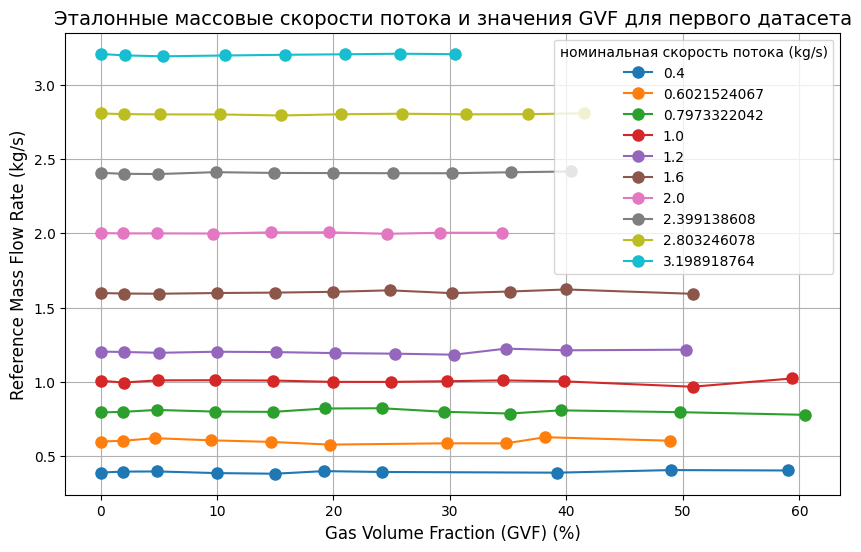

In [4]:
plt.figure(figsize=(10, 6))

# Сортируем данные по оси X для правильного соединения линий
df1_sorted = df.sort_values('GVF [%]')

# Рисуем линии с маркерами для каждой группы
for name, group in df1_sorted.groupby('Nominal Mass Flow [kg/s]'):
    plt.plot(group['GVF [%]'], group['Ref Mass Flow [kg/s]'],
             marker='o',  # добавляем точки
             linestyle='-',  # сплошная линия
             markersize=8,  # размер точек
             label=name)  # легенда

plt.title('Эталонные массовые скорости потока и значения GVF для первого датасета', fontsize=14)
plt.xlabel('Gas Volume Fraction (GVF) (%)', fontsize=12)
plt.ylabel('Reference Mass Flow Rate (kg/s)', fontsize=12)
plt.legend(title='номинальная скорость потока (kg/s)')
plt.grid(True)
plt.savefig('ms_gvf_df1.png', dpi=300, bbox_inches='tight')
plt.show()

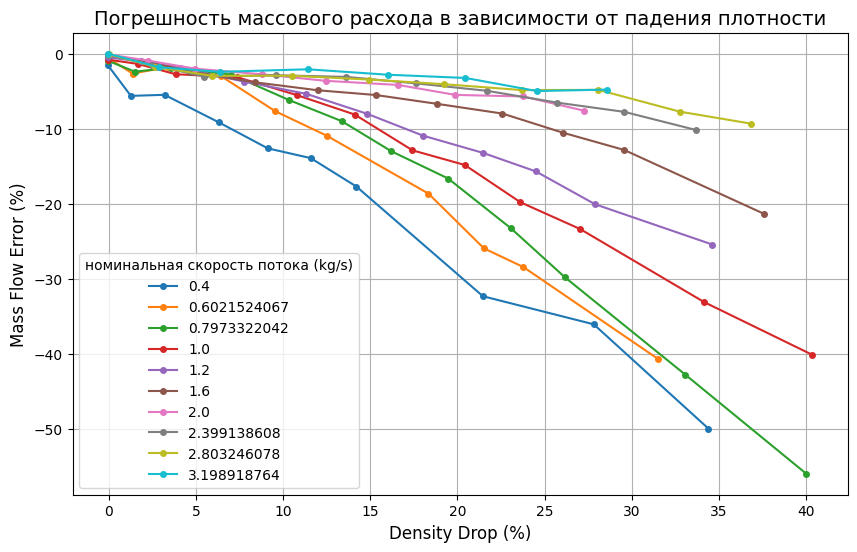

In [5]:
plt.figure(figsize=(10, 6))

# Сортируем данные по оси X для правильного соединения линий
df1_sorted = df.sort_values('Cor Density Drop [%]')

# Рисуем линии с маркерами для каждой группы
for name, group in df1_sorted.groupby('Nominal Mass Flow [kg/s]'):
    plt.plot(group['Cor Density Drop [%]'], group['Err Mass Flow [%]'],
             marker='o',  # добавляем точки
             linestyle='-',  # сплошная линия
             markersize=4,  # размер точек
             label=name)  # легенда

plt.title('Погрешность массового расхода в зависимости от падения плотности', fontsize=14)
plt.xlabel('Density Drop (%)', fontsize=12)
plt.ylabel('Mass Flow Error (%)', fontsize=12)
plt.legend(title='номинальная скорость потока (kg/s)')
plt.grid(True)
plt.savefig('ms_gvf_df1.png', dpi=300, bbox_inches='tight')
plt.show()

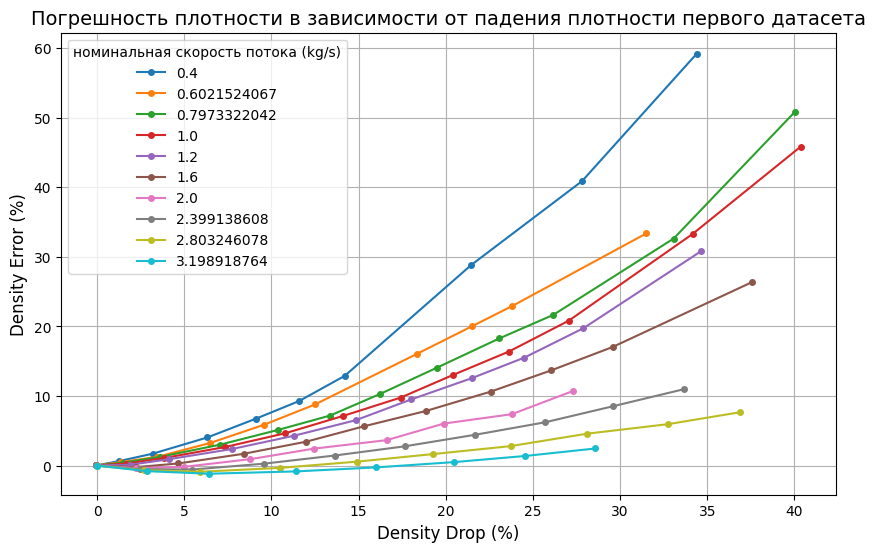

In [6]:

plt.figure(figsize=(10, 6))

# Сортируем данные по оси X для правильного соединения линий
df1_sorted = df.sort_values('Cor Density Drop [%]')

# Рисуем линии с маркерами для каждой группы
for name, group in df1_sorted.groupby('Nominal Mass Flow [kg/s]'):
    plt.plot(group['Cor Density Drop [%]'], group['Err Density [%]'],
             marker='o',  # добавляем точки
             linestyle='-',  # сплошная линия
             markersize=4,  # размер точек
             label=name)  # легенда

plt.title('Погрешность плотности в зависимости от падения плотности первого датасета', fontsize=14)
plt.xlabel('Density Drop (%)', fontsize=12)
plt.ylabel('Density Error (%)', fontsize=12)
plt.legend(title='номинальная скорость потока (kg/s)')
plt.grid(True)
plt.savefig('ms_gvf_df1.png', dpi=300, bbox_inches='tight')
plt.show()

# Метрические методы

## Вспомогательные функции

In [7]:
def compute_metrics(y_true, y_pred):
    """
    Вычисляет основные метрики регрессии:
    - MSE: среднеквадратичная ошибка
    - RMSE: корень из MSE (в тех же единицах, что и целевая переменная)
    - MAE: средняя абсолютная ошибка (в статье используется как основная метрика)
    - MAPE: средняя абсолютная процентная ошибка (удобно для сравнения с % ошибками)

    Вход:
        y_true — истинные значения (например, Err Mass Flow [%])
        y_pred — предсказанные значения

    Возвращает словарь с метриками.

    В статье: MAE — основная метрика (таблицы 5–6), усреднённая по 20 запускам.
    """
    # MSE: (1/n) * Σ(y_true - y_pred)²
    mse = np.mean((y_true - y_pred)**2)

    # RMSE = √MSE — интерпретируемая ошибка в % (как и целевая переменная)
    rmse = np.sqrt(mse)

    # MAE: (1/n) * Σ|y_true - y_pred| — ключевая метрика в статье
    mae = np.mean(np.abs(y_true - y_pred))

    # MAPE: средняя % ошибка, +1e-8 чтобы избежать деления на 0
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

def correct_values(observed, error_pred_percent):
    """
    Корректирует измеренное значение по предсказанной ошибке.

    Формула из статьи (см. Section 1):
        m_corr = m_obs / (1 + m_err/100)

    Вход:
        observed — измеренное значение (m_obs или ρ_obs)
        error_pred_percent — предсказанная ошибка в % (m_err или ρ_err)

    Возвращает: исправленное (истинное) значение.

    Пример:
        observed = 1.0 кг/с, error_pred = -20% → corrected = 1.0 / (1 - 0.2) = 1.25 кг/с
    """
    return observed / (1 + error_pred_percent / 100)

def knn_predict_kdtree_weighted(X_train, y_train, X_test, k, h, kernel_type='gaussian'):
    """
    KNN-регрессия с:
    - KDTree для ускорения поиска соседей
    - Взвешиванием по ядру (gaussian, triangular, rectangular)
    - Параметром h — ширина ядра (аналогично bandwidth в KDE)

    Использует структуру KDTree из scipy — O(log n) вместо O(n) на точку.

    Вход:
        X_train — стандартизированные признаки (2D: m_obs, dd)
        y_train — целевые ошибки (%)
        X_test — тестовые точки
        k — число соседей
        h — ширина ядра
        kernel_type — тип ядра

    Возвращает: предсказанные ошибки.
    """
    tree = KDTree(X_train)
    preds = []
    for x in X_test:
        dists, idx = tree.query(x, k=k)
        w = kernel_weights(dists, h, kernel_type)
        pred = np.sum(w * y_train[idx]) / (np.sum(w) + 1e-12)
        preds.append(pred)
    return np.array(preds)

def knn_predict(X_train, y_train, X_test, k):
    """
    Классический KNN без оптимизации.
    Для каждой тестовой точки:
        - Считает расстояние до ВСЕХ точек в X_train
        - Берёт k ближайших
        - Усредняет их y

    Медленный: O(n * m), где n — тест, m — train.
    """
    preds = []
    for x in X_test:
        dists = np.linalg.norm(X_train - x, axis=1)
        idx = np.argsort(dists)[:k]
        preds.append(np.mean(y_train[idx]))
    return np.array(preds)

def knn_predict_weighted(X_train, y_train, X_test, k, eps=1e-6):
    """
    KNN с весами, обратно пропорциональными расстоянию:
        w_i = 1 / (d_i + eps)

    Ближайшие соседи влияют сильнее.
    """
    preds = []
    for x in X_test:
        dists = np.linalg.norm(X_train - x, axis=1)        # Евклидово расстояние
        idx = np.argsort(dists)[:k]                        # k ближайших соседей
        w = 1 / (dists[idx] + eps)                         # ← ВЕСА
        pred = np.sum(y_train[idx] * w) / np.sum(w)
        preds.append(pred)
    return np.array(preds)

def knn_predict_kdtree(X_train, y_train, X_test, k):
    """
    Оптимизированный KNN (KDTree), но без весов — просто среднее по k соседям.
    """
    tree = KDTree(X_train)
    preds = []
    for x in X_test:
        dists, idx = tree.query(x, k=k)
        preds.append(np.mean(y_train[idx]))
    return np.array(preds)

def knn_predict_weighted_gaussian(X_train, y_train, X_test, k, h):
    """
    Weighted KNN with Gaussian kernel (no KDTree)
    """
    preds = []
    for x in X_test:
        dists = np.linalg.norm(X_train - x, axis=1)
        # Гауссово ядро: w = exp(-0.5 * (d/h)^2)
        weights = np.exp(-0.5 * (dists / h) ** 2)
        # Берём k ближайших соседей
        idx = np.argsort(dists)[:k]
        w_k = weights[idx]
        y_k = y_train[idx]
        pred = np.sum(w_k * y_k) / (np.sum(w_k) + 1e-12)
        preds.append(pred)
    return np.array(preds)

def kernel_weights(dist, h, kernel_type):
    """
    Вычисляет веса по расстоянию с помощью ядра.

    u = dist / h — нормированное расстояние

    Ядра:
    - rectangular: 1 если |u| ≤ 1, иначе 0
    - triangular: (1 - |u|) если |u| ≤ 1
    - gaussian: exp(-0.5*u²) / √(2π) — как плотность нормального распределения

    В статье: не используется, но это мощное расширение KNN.
    """
    u = dist / h
    if kernel_type == 'rectangular':
        return np.where(np.abs(u) <= 1, 1.0, 0.0)
    elif kernel_type == 'triangular':
        return np.where(np.abs(u) <= 1, 1 - np.abs(u), 0.0)
    elif kernel_type == 'gaussian':
        return np.exp(-0.5 * u**2) / np.sqrt(2 * np.pi)
    else:
        raise ValueError("Unknown kernel")

## KNN (k-Nearest Neighbors)
**Идея**: Предсказание — среднее значение целевой переменной у k ближайших соседей.

**Плюсы**:
- Простота реализации
- Не требует обучения
- Адаптивен к локальной структуре данных

**Минусы**:
- Вычислительно затратен при большом объёме данных
- Чувствителен к масштабу признаков и выбросам

## Взвешенный KNN
**Идея**: Ближайшие соседи вносят больший вклад. Веса обычно обратно пропорциональны расстоянию:

$( w_i = \frac{1}{d_i + \epsilon} ) или ( w_i = \exp(-\frac{d_i^2}{2h^2}) )$

**Плюсы**:
- Улучшает точность за счёт учёта "близости" соседей

**Минусы**:
- Требует подбора функции весов и гиперпараметров (например, h)

## Kernel Regression (Ядерная регрессия)
**Идея**: Взвешенное среднее всех точек, где вес определяется ядром (например, гауссовым):

$( \hat{y}(x) = \frac{\sum_i K(\frac{\|x - x_i\|}{h}) y_i}{\sum_i K(\frac{\|x - x_i\|}{h})} )$

**Плюсы**:
- Гладкие предсказания
- Гибкость через выбор ядра

**Минусы**:
- Высокая вычислительная сложность (O(n))
- Чувствителен к bandwidth h

## K-d дерево (k-dimensional tree)
**Идея**: Структура данных для быстрого поиска ближайших соседей в многомерном пространстве.

**Применение**: Ускоряет KNN и ядерные методы (снижает сложность поиска с O(n) до ~O(log n))

**Плюсы**:
- Эффективен при умеренной размерности (до ~20 признаков)

**Минусы**:
- Эффективность падает в высоких размерностях ("проклятие размерности")

## Подбор гипер параметров

In [8]:
# @title
# ------------------------------------------------------------
# 4. Подбор гиперпараметров для всех KNN-подобных моделей
# ------------------------------------------------------------
# =============================================================================
# Цель: найти оптимальные k (число соседей) и h (ширина ядра) для минимизации RMSE
#       после коррекции измерений (формула из статьи: m_corr = m_obs / (1 + err/100))
#
# Используем hold-out (X_test_norm) — честная оценка обобщения
# В статье: обучают на подмножествах, тестируют на полном наборе → мы делаем наоборот
#
# Метрика: RMSE по ИСПРАВЛЕННЫМ значениям (не по ошибке!) — физически осмысленно
# =============================================================================

# Общий диапазон k
k_range = np.arange(1, 16)
# h_range: ширина ядра для взвешенных KNN
h_range = np.arange(0.1, 3.1, 0.2)

# ---------- 4.1. Обычный KNN ----------
print(" → Обычный KNN...")
best_k_knn_mf = best_k_knn_rho = 1
best_rmse_knn_mf = best_rmse_knn_rho = np.inf

for k in k_range:
  # Предсказание ошибки массового расхода
    pred_mf = knn_predict(X_train_norm, y_mf_train, X_test_norm, k)
    # Коррекция: m_corr = m_obs / (1 + err/100)
    corr_mf = correct_values(m_obs_test, pred_mf)
    # RMSE по СКОРРЕКТИРОВАННЫМ значениям (не по ошибке!)
    rmse_mf = np.sqrt(np.mean((corr_mf - m_true_test)**2))
    if rmse_mf < best_rmse_knn_mf:
        best_rmse_knn_mf, best_k_knn_mf = rmse_mf, k
    # Аналогично для плотности
    pred_rho = knn_predict(X_train_norm, y_rho_train, X_test_norm, k)
    corr_rho = correct_values(rho_obs_test, pred_rho)
    rmse_rho = np.sqrt(np.mean((corr_rho - rho_true_test)**2))
    if rmse_rho < best_rmse_knn_rho:
        best_rmse_knn_rho, best_k_knn_rho = rmse_rho, k

print(f"   Mass Flow: k={best_k_knn_mf}, RMSE={best_rmse_knn_mf:.4f}")
print(f"   Density:   k={best_k_knn_rho}, RMSE={best_rmse_knn_rho:.4f}")

# ---------- 4.2. Weighted KNN ----------
print(" → Weighted KNN...")
best_k_wknn_mf = best_k_wknn_rho = 1
best_rmse_wknn_mf = best_rmse_wknn_rho = np.inf

for k in k_range:
    pred_mf = knn_predict_weighted(X_train_norm, y_mf_train, X_test_norm, k)
    corr_mf = correct_values(m_obs_test, pred_mf)
    rmse_mf = np.sqrt(np.mean((corr_mf - m_true_test)**2))
    if rmse_mf < best_rmse_wknn_mf:
        best_rmse_wknn_mf, best_k_wknn_mf = rmse_mf, k

    pred_rho = knn_predict_weighted(X_train_norm, y_rho_train, X_test_norm, k)
    corr_rho = correct_values(rho_obs_test, pred_rho)
    rmse_rho = np.sqrt(np.mean((corr_rho - rho_true_test)**2))
    if rmse_rho < best_rmse_wknn_rho:
        best_rmse_wknn_rho, best_k_wknn_rho = rmse_rho, k

print(f"   Mass Flow: k={best_k_wknn_mf}, RMSE={best_rmse_wknn_mf:.4f}")
print(f"   Density:   k={best_k_wknn_rho}, RMSE={best_rmse_wknn_rho:.4f}")

# ---------- 4.35. Weighted KNN (Gaussian kernel, no KDTree) ----------
print(" → Weighted KNN (Gaussian kernel)...")
rmse_mf_grid_wg = np.full((len(k_range), len(h_range)), np.inf)
rmse_rho_grid_wg = np.full((len(k_range), len(h_range)), np.inf)

best_mf_wg = {'rmse': np.inf, 'k': None, 'h': None}
best_rho_wg = {'rmse': np.inf, 'k': None, 'h': None}

for i, k in enumerate(k_range):
    for j, h in enumerate(h_range):
        # Mass Flow
        pred_mf = knn_predict_weighted_gaussian(X_train_norm, y_mf_train, X_test_norm, k, h)
        corr_mf = correct_values(m_obs_test, pred_mf)
        rmse_mf = np.sqrt(np.mean((corr_mf - m_true_test)**2))
        rmse_mf_grid_wg[i, j] = rmse_mf

        # Density
        pred_rho = knn_predict_weighted_gaussian(X_train_norm, y_rho_train, X_test_norm, k, h)
        corr_rho = correct_values(rho_obs_test, pred_rho)
        rmse_rho = np.sqrt(np.mean((corr_rho - rho_true_test)**2))
        rmse_rho_grid_wg[i, j] = rmse_rho

        if rmse_mf < best_mf_wg['rmse']:
            best_mf_wg.update({'rmse': rmse_mf, 'k': k, 'h': h})
        if rmse_rho < best_rho_wg['rmse']:
            best_rho_wg.update({'rmse': rmse_rho, 'k': k, 'h': h})

print(f"   Mass Flow → k={best_mf_wg['k']}, h={best_mf_wg['h']:.1f}, RMSE={best_mf_wg['rmse']:.4f}")
print(f"   Density   → k={best_rho_wg['k']}, h={best_rho_wg['h']:.1f}, RMSE={best_rho_wg['rmse']:.4f}")

# ---------- 4.3. K-d Tree KNN ----------
print(" → K-d Tree KNN...")
best_k_kdtree_mf = best_k_kdtree_rho = 1
best_rmse_kdtree_mf = best_rmse_kdtree_rho = np.inf

for k in k_range:
    pred_mf = knn_predict_kdtree(X_train_norm, y_mf_train, X_test_norm, k)
    corr_mf = correct_values(m_obs_test, pred_mf)
    rmse_mf = np.sqrt(np.mean((corr_mf - m_true_test)**2))
    if rmse_mf < best_rmse_kdtree_mf:
        best_rmse_kdtree_mf, best_k_kdtree_mf = rmse_mf, k

    pred_rho = knn_predict_kdtree(X_train_norm, y_rho_train, X_test_norm, k)
    corr_rho = correct_values(rho_obs_test, pred_rho)
    rmse_rho = np.sqrt(np.mean((corr_rho - rho_true_test)**2))
    if rmse_rho < best_rmse_kdtree_rho:
        best_rmse_kdtree_rho, best_k_kdtree_rho = rmse_rho, k

print(f"   Mass Flow: k={best_k_kdtree_mf}, RMSE={best_rmse_kdtree_mf:.4f}")
print(f"   Density:   k={best_k_kdtree_rho}, RMSE={best_rmse_kdtree_rho:.4f}")

print(" → K-d Tree + Weighted Kernels...")

kernels = ['rectangular', 'triangular', 'gaussian']
best_per_kernel = {}

for kernel in kernels:
    print(f"   Подбор для ядра: {kernel}")
    rmse_mf_grid = np.full((len(k_range), len(h_range)), np.inf)
    rmse_rho_grid = np.full((len(k_range), len(h_range)), np.inf)

    best_mf = {'rmse': np.inf, 'k': None, 'h': None}
    best_rho = {'rmse': np.inf, 'k': None, 'h': None}

    for i, k in enumerate(k_range):
        for j, h in enumerate(h_range):
            # Mass Flow
            pred_mf = knn_predict_kdtree_weighted(X_train_norm, y_mf_train, X_test_norm, k, h, kernel)
            corr_mf = correct_values(m_obs_test, pred_mf)
            rmse_mf = np.sqrt(np.mean((corr_mf - m_true_test)**2))
            rmse_mf_grid[i, j] = rmse_mf

            # Density
            pred_rho = knn_predict_kdtree_weighted(X_train_norm, y_rho_train, X_test_norm, k, h, kernel)
            corr_rho = correct_values(rho_obs_test, pred_rho)
            rmse_rho = np.sqrt(np.mean((corr_rho - rho_true_test)**2))
            rmse_rho_grid[i, j] = rmse_rho

            if rmse_mf < best_mf['rmse']:
                best_mf.update({'rmse': rmse_mf, 'k': k, 'h': h})
            if rmse_rho < best_rho['rmse']:
                best_rho.update({'rmse': rmse_rho, 'k': k, 'h': h})

    best_per_kernel[kernel] = {'mf': best_mf, 'rho': best_rho}
    print(f"     Mass Flow → k={best_mf['k']}, h={best_mf['h']:.1f}, RMSE={best_mf['rmse']:.4f}")
    print(f"     Density   → k={best_rho['k']}, h={best_rho['h']:.1f}, RMSE={best_rho['rmse']:.4f}")

 → Обычный KNN...
   Mass Flow: k=2, RMSE=0.0379
   Density:   k=6, RMSE=7.4274
 → Weighted KNN...
   Mass Flow: k=2, RMSE=0.0400
   Density:   k=6, RMSE=6.2513
 → Weighted KNN (Gaussian kernel)...
   Mass Flow → k=2, h=2.9, RMSE=0.0379
   Density   → k=10, h=0.1, RMSE=5.7877
 → K-d Tree KNN...
   Mass Flow: k=2, RMSE=0.0379
   Density:   k=6, RMSE=7.4274
 → K-d Tree + Weighted Kernels...
   Подбор для ядра: rectangular
     Mass Flow → k=2, h=0.3, RMSE=0.0379
     Density   → k=6, h=0.3, RMSE=6.0866
   Подбор для ядра: triangular
     Mass Flow → k=2, h=2.9, RMSE=0.0380
     Density   → k=6, h=0.3, RMSE=5.4020
   Подбор для ядра: gaussian
     Mass Flow → k=2, h=2.9, RMSE=0.0379
     Density   → k=10, h=0.1, RMSE=5.7877


# Почему RMSE используется при подборе гиперпараметров?

Поскольку у KNN нет внутренней функции потерь, гиперпараметры (k, h) подбираются внешним циклом, и для оценки качества каждой комбинации нужна метрика качества.

##  Преимущества RMSE:

### Физическая интерпретируемость
- **RMSE имеет те же единицы, что и целевая переменная:**
  - кг/с — для массового расхода
  - кг/м³ — для плотности

### Штраф за большие ошибки
- В задачах измерения крупные ошибки недопустимы
- RMSE сильнее штрафует выбросы

### Стандарт в метрологии и инженерии
- RMSE — общепринятая метрика для оценки точности измерительных систем
- Позволяет сравнивать результаты с другими исследованиями и промышленными стандартами

##  Итоговый выбор:
RMSE оптимальна для промышленных задач прогнозирования, где важна физическая интерпретация и недопустимы крупные ошибки.

# Методы на основе ближайших соседей



## KNN

In [9]:
# =============================================================================
# 5. ФИНАЛЬНАЯ ОЦЕНКА ОПТИМИЗИРОВАННОЙ KNN МОДЕЛИ
# =============================================================================
# После подбора гиперпараметров (best_k_knn_mf, best_k_knn_rho)
# мы применяем лучшую модель к тестовым данным и оцениваем результат
# =============================================================================

# 1. Предсказание ошибки массового расхода (в %) на тестовом наборе
#    Используем ОПТИМАЛЬНОЕ k, найденное ранее
#    knn_predict — обычный KNN без весов, но с лучшим k
pred_mf = knn_predict(
    X_train_norm,   # Обучающие признаки (m_obs, dd), стандартизированные
    y_mf_train,     # Истинные ошибки массового расхода на train (в %)
    X_test_norm,    # Тестовые признаки (m_obs, dd)
    best_k_knn_mf   # Лучшее k, найденное по RMSE по m_corr
)
# → pred_mf: массив предсказанных ошибок m_err (%) для каждой тестовой точки

# 2. Предсказание ошибки плотности (в %)
pred_rho = knn_predict(
    X_train_norm, y_rho_train, X_test_norm, best_k_knn_rho
)
# → pred_rho: массив предсказанных ошибок ρ_err (%)

# 3. Коррекция измеренных значений
#    Формула из статьи (3): m_corr = m_obs / (1 + m_err/100)
corr_m = correct_values(m_obs_test, pred_mf)
# → corr_m: исправленный массовый расход (в кг/с), ближе к истинному

corr_rho = correct_values(rho_obs_test, pred_rho)
# → corr_rho: исправленная плотность (в кг/м³)

# 4. Оценка качества КОРРЕКЦИИ
#    compute_metrics(true, corrected) → MSE, RMSE, MAE между ИСТИННЫМ и ИСПРАВЛЕННЫМ
results_summary.append({
    'Model': 'KNN (tuned)',
    'Target': 'Mass Flow',
    **compute_metrics(m_true_test, corr_m)  # ← распаковка словаря
})
# → добавляем в таблицу: MSE, RMSE, MAE между m_true и m_corr

results_summary.append({
    'Model': 'KNN (tuned)',
    'Target': 'Density',
    **compute_metrics(rho_true_test, corr_rho)
})

## Weighted KNN

In [10]:
pred_mf = knn_predict_weighted(X_train_norm, y_mf_train, X_test_norm, best_k_wknn_mf)
pred_rho = knn_predict_weighted(X_train_norm, y_rho_train, X_test_norm, best_k_wknn_rho)
corr_m = correct_values(m_obs_test, pred_mf)
corr_rho = correct_values(rho_obs_test, pred_rho)
results_summary.append({'Model': 'Weighted KNN (tuned)', 'Target': 'Mass Flow', **compute_metrics(m_true_test, corr_m)})
results_summary.append({'Model': 'Weighted KNN (tuned)', 'Target': 'Density', **compute_metrics(rho_true_test, corr_rho)})

In [11]:
pred_mf = knn_predict_weighted_gaussian(X_train_norm, y_mf_train, X_test_norm, best_mf_wg['k'], best_mf_wg['h'])
pred_rho = knn_predict_weighted_gaussian(X_train_norm, y_rho_train, X_test_norm, best_rho_wg['k'], best_rho_wg['h'])
corr_m = correct_values(m_obs_test, pred_mf)
corr_rho = correct_values(rho_obs_test, pred_rho)
results_summary.append({'Model': 'Weighted KNN (Gaussian, tuned)', 'Target': 'Mass Flow', **compute_metrics(m_true_test, corr_m)})
results_summary.append({'Model': 'Weighted KNN (Gaussian, tuned)', 'Target': 'Density', **compute_metrics(rho_true_test, corr_rho)})

## K-d Tree KNN

In [12]:
pred_mf = knn_predict_kdtree(X_train_norm, y_mf_train, X_test_norm, best_k_kdtree_mf)
pred_rho = knn_predict_kdtree(X_train_norm, y_rho_train, X_test_norm, best_k_kdtree_rho)
corr_m = correct_values(m_obs_test, pred_mf)
corr_rho = correct_values(rho_obs_test, pred_rho)
results_summary.append({'Model': 'K-d Tree KNN (tuned)', 'Target': 'Mass Flow', **compute_metrics(m_true_test, corr_m)})
results_summary.append({'Model': 'K-d Tree KNN (tuned)', 'Target': 'Density', **compute_metrics(rho_true_test, corr_rho)})

## K-d Tree + Gaussian

In [13]:
# ---------- 5.5. K-d Tree + Weighted Kernels (tuned) ----------
for kernel in kernels:
    model_name = f"K-d Tree + {kernel.capitalize()} (tuned)"
    best_mf = best_per_kernel[kernel]['mf']
    best_rho = best_per_kernel[kernel]['rho']

    pred_mf = knn_predict_kdtree_weighted(X_train_norm, y_mf_train, X_test_norm, best_mf['k'], best_mf['h'], kernel)
    pred_rho = knn_predict_kdtree_weighted(X_train_norm, y_rho_train, X_test_norm, best_rho['k'], best_rho['h'], kernel)

    corr_m = correct_values(m_obs_test, pred_mf)
    corr_rho = correct_values(rho_obs_test, pred_rho)

    results_summary.append({'Model': model_name, 'Target': 'Mass Flow', **compute_metrics(m_true_test, corr_m)})
    results_summary.append({'Model': model_name, 'Target': 'Density', **compute_metrics(rho_true_test, corr_rho)})

##  Выводы

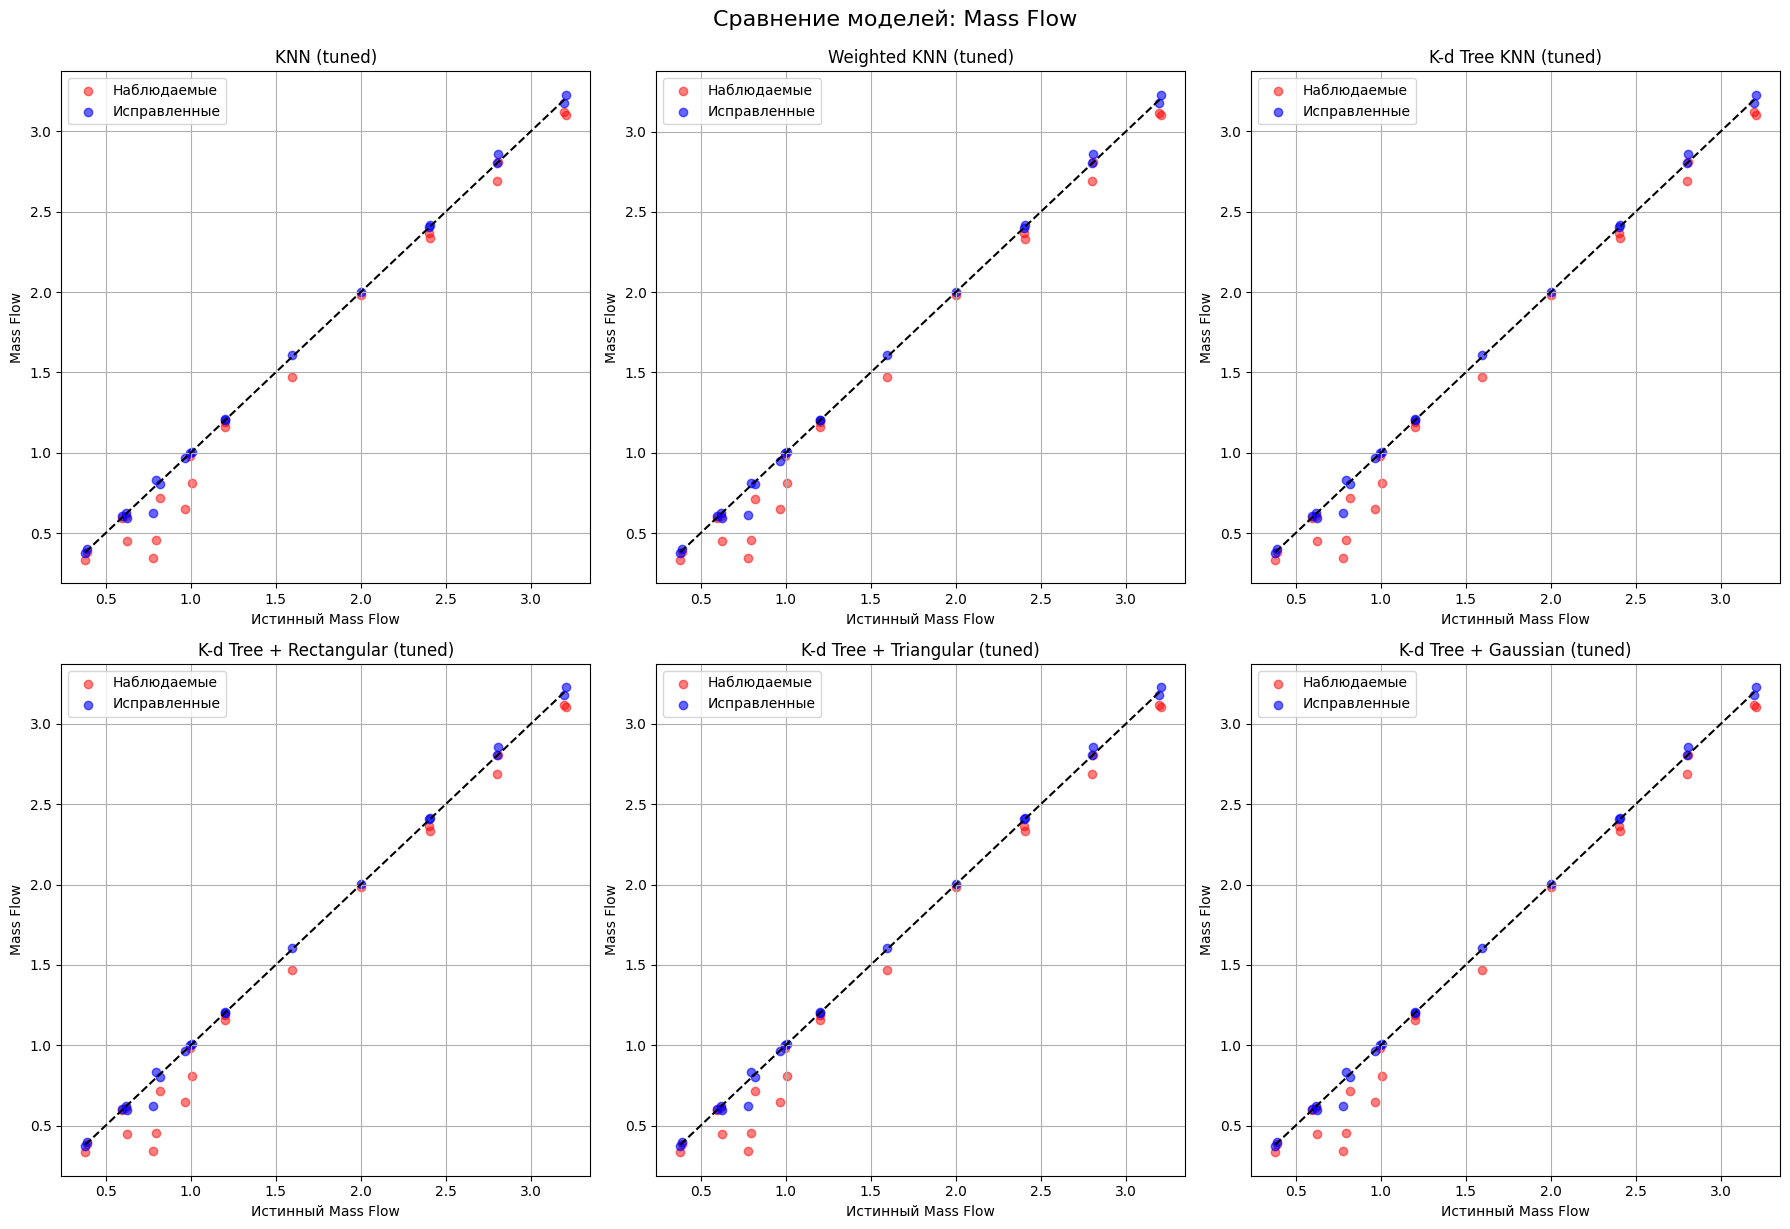

In [14]:
# @title
models_for_plot = {
    'KNN (tuned)': (knn_predict, {'k_m': best_k_knn_mf, 'k_rho': best_k_knn_rho}),
    'Weighted KNN (tuned)': (knn_predict_weighted, {'k_m': best_k_wknn_mf, 'k_rho': best_k_wknn_rho}),
    'K-d Tree KNN (tuned)': (knn_predict_kdtree, {'k_m': best_k_kdtree_mf, 'k_rho': best_k_kdtree_rho}),
    'K-d Tree + Rectangular (tuned)': (knn_predict_kdtree_weighted, {
        'k_m': best_per_kernel['rectangular']['mf']['k'],
        'k_rho': best_per_kernel['rectangular']['rho']['k'],
        'h_m': best_per_kernel['rectangular']['mf']['h'],
        'h_rho': best_per_kernel['rectangular']['rho']['h'],
        'kernel': 'rectangular'
    }),
    'K-d Tree + Triangular (tuned)': (knn_predict_kdtree_weighted, {
        'k_m': best_per_kernel['triangular']['mf']['k'],
        'k_rho': best_per_kernel['triangular']['rho']['k'],
        'h_m': best_per_kernel['triangular']['mf']['h'],
        'h_rho': best_per_kernel['triangular']['rho']['h'],
        'kernel': 'triangular'
    }),
    'K-d Tree + Gaussian (tuned)': (knn_predict_kdtree_weighted, {
        'k_m': best_per_kernel['gaussian']['mf']['k'],
        'k_rho': best_per_kernel['gaussian']['rho']['k'],
        'h_m': best_per_kernel['gaussian']['mf']['h'],
        'h_rho': best_per_kernel['gaussian']['rho']['h'],
        'kernel': 'gaussian'
    }),
}

# Mass Flow
plt.figure(figsize=(18, 12))
model_names = list(models_for_plot.keys())
for i, name in enumerate(model_names, 1):
    func, params = models_for_plot[name]
    if 'kernel' in params:
        pred = func(X_train_norm, y_mf_train, X_test_norm, params['k_m'], params['h_m'], params['kernel'])
    elif name in ['KNN (tuned)', 'Weighted KNN (tuned)', 'K-d Tree KNN (tuned)']:
        pred = func(X_train_norm, y_mf_train, X_test_norm, params['k_m'])
    else:
        continue
    corr = correct_values(m_obs_test, pred)
    plt.subplot(2, 3, i)
    plt.scatter(m_true_test, m_obs_test, color='red', alpha=0.5, label='Наблюдаемые')
    plt.scatter(m_true_test, corr, color='blue', alpha=0.6, label='Исправленные')
    plt.plot([m_true_test.min(), m_true_test.max()], [m_true_test.min(), m_true_test.max()], 'k--')
    plt.title(name)
    plt.xlabel('Истинный Mass Flow')
    plt.ylabel('Mass Flow')
    plt.legend(); plt.grid(True)
plt.tight_layout()
plt.suptitle("Сравнение моделей: Mass Flow", y=1.02, fontsize=16)
plt.show()

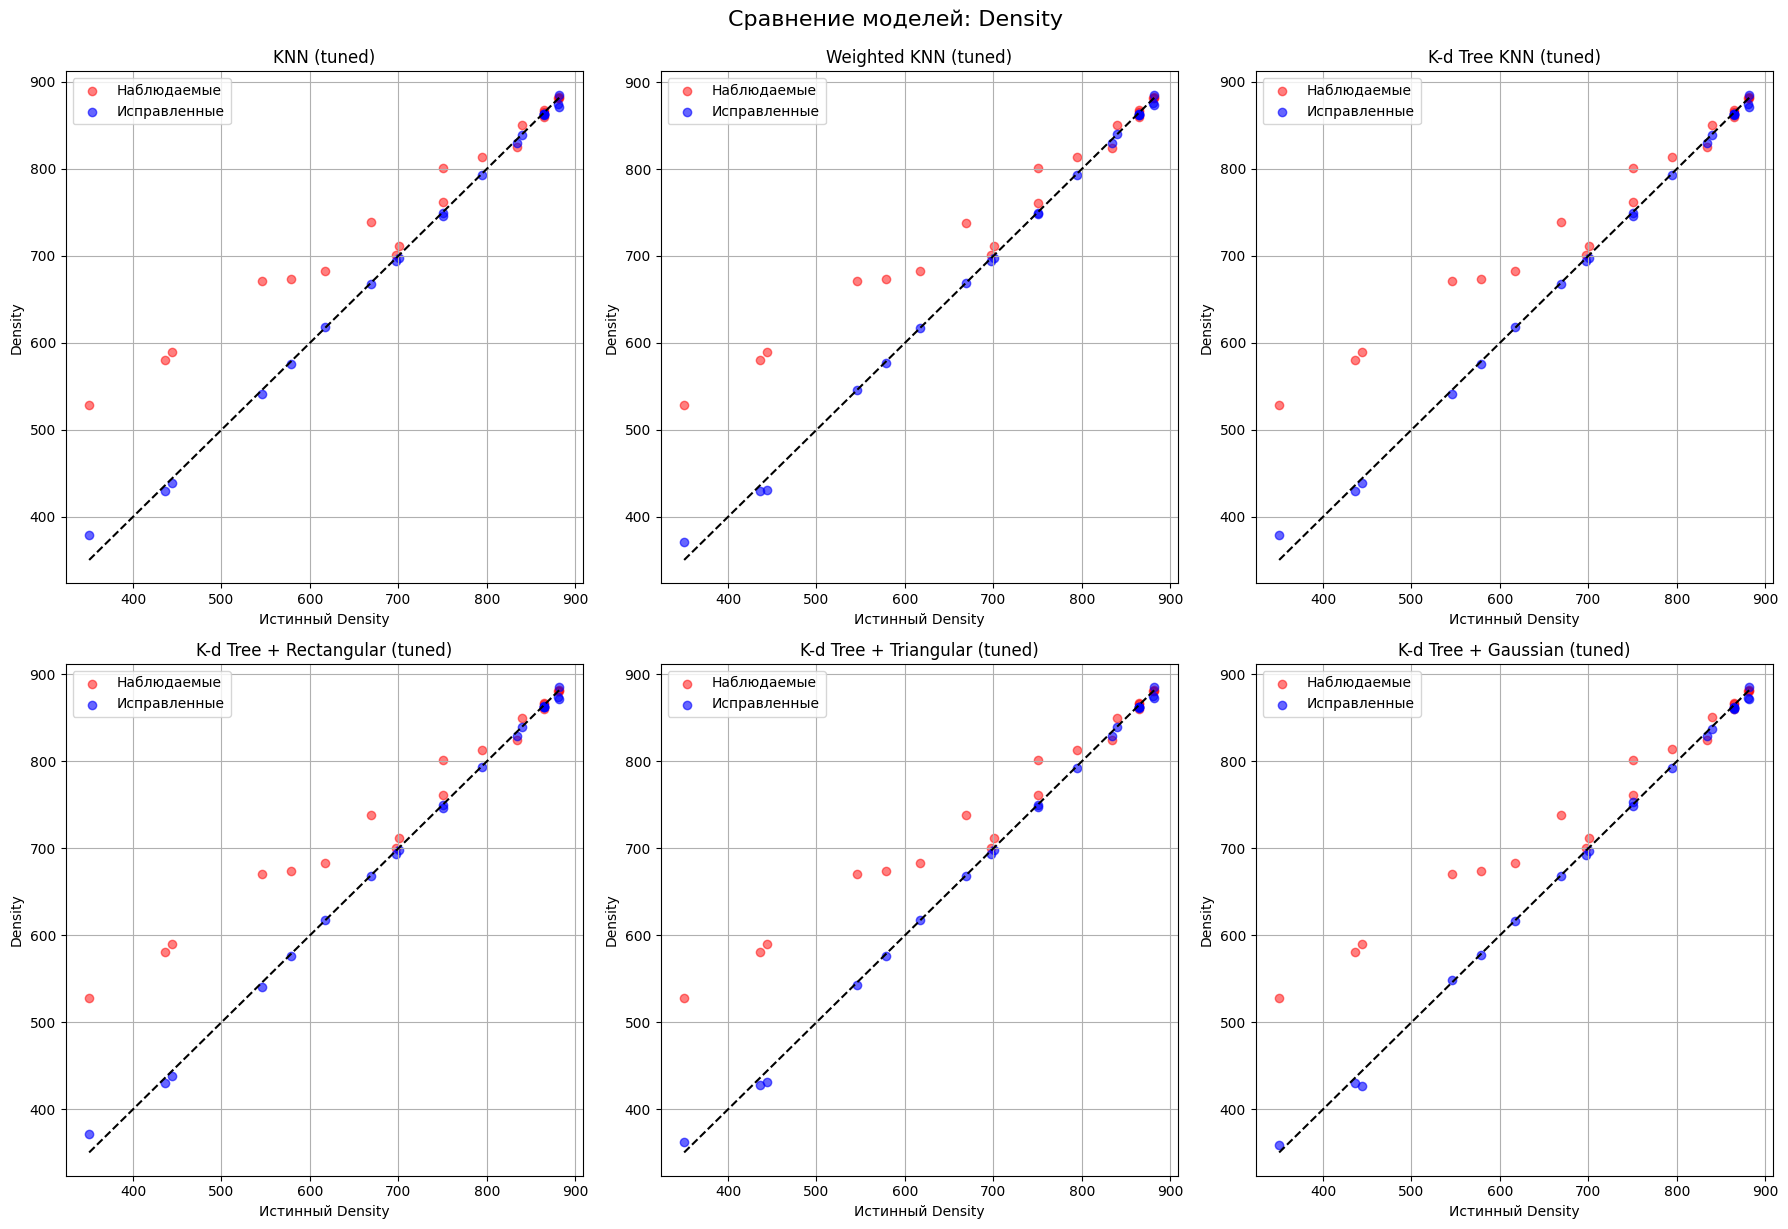

In [15]:
# @title
# Density
plt.figure(figsize=(18, 12))
model_names = list(models_for_plot.keys())
for i, name in enumerate(model_names, 1):
    func, params = models_for_plot[name]
    if 'kernel' in params:
        pred = func(X_train_norm, y_rho_train, X_test_norm, params['k_rho'], params['h_rho'], params['kernel'])
    elif name in ['KNN (tuned)', 'Weighted KNN (tuned)', 'K-d Tree KNN (tuned)']:
        pred = func(X_train_norm, y_rho_train, X_test_norm, params['k_rho'])
    else:
        continue
    corr = correct_values(rho_obs_test, pred)
    plt.subplot(2, 3, i)
    plt.scatter(rho_true_test, rho_obs_test, color='red', alpha=0.5, label='Наблюдаемые')
    plt.scatter(rho_true_test, corr, color='blue', alpha=0.6, label='Исправленные')
    plt.plot([rho_true_test.min(), rho_true_test.max()], [rho_true_test.min(), rho_true_test.max()], 'k--')
    plt.title(name)
    plt.xlabel('Истинный Density')
    plt.ylabel('Density')
    plt.legend(); plt.grid(True)
plt.tight_layout()
plt.suptitle("Сравнение моделей: Density", y=1.02, fontsize=16)
plt.show()

In [16]:
# @title
# Преобразуем в DataFrame
results_df = pd.DataFrame(results_summary)

# Применяем градиентную раскраску по метрикам (MSE, RMSE, MAE, MAPE)
# Цвета: зелёный (лучше) → жёлтый → красный (хуже)
styled_df = results_df.style.background_gradient(
    cmap='RdYlGn_r',  # "Red-Yellow-Green", reversed: min=green, max=red
    subset=['MSE', 'RMSE', 'MAE', 'MAPE'],
    vmin=None,
    vmax=None
).format({
    'MSE': '{:.6f}',
    'RMSE': '{:.6f}',
    'MAE': '{:.6f}',
    'MAPE': '{:.3f}'
})

display(styled_df)

print("\n" + "="*60)
print(" "*20 + "ЛУЧШИЕ МОДЕЛИ ПО RMSE")
print("="*60)

# Для Mass Flow
mf_results = results_df[results_df['Target'] == 'Mass Flow']
best_mf_row = mf_results.loc[mf_results['RMSE'].idxmin()]
print(f"Лучшая модель для Mass Flow: {best_mf_row['Model']}")
print(f"   RMSE = {best_mf_row['RMSE']:.6f} kg/s")


# Для Density
rho_results = results_df[results_df['Target'] == 'Density']
best_rho_row = rho_results.loc[rho_results['RMSE'].idxmin()]
print(f"\n Лучшая модель для Density: {best_rho_row['Model']}")
print(f"   RMSE = {best_rho_row['RMSE']:.6f} kg/m³")

,Model,Target,MSE,RMSE,MAE,MAPE
0,KNN (tuned),Mass Flow,0.001438,0.037925,0.019036,2.071
1,KNN (tuned),Density,55.166812,7.427436,4.520154,0.852
2,Weighted KNN (tuned),Mass Flow,0.001602,0.040022,0.019150,2.105
3,Weighted KNN (tuned),Density,39.079315,6.251345,4.003101,0.750
4,"Weighted KNN (Gaussian, tuned)",Mass Flow,0.001439,0.037929,0.019037,2.071
5,"Weighted KNN (Gaussian, tuned)",Density,33.497011,5.787660,4.340340,0.718
6,K-d Tree KNN (tuned),Mass Flow,0.001438,0.037925,0.019036,2.071
7,K-d Tree KNN (tuned),Density,55.166812,7.427436,4.520154,0.852
8,K-d Tree + Rectangular (tuned),Mass Flow,0.001438,0.037925,0.019036,2.071
9,K-d Tree + Rectangular (tuned),Density,37.047202,6.086641,4.154457,0.748



                    ЛУЧШИЕ МОДЕЛИ ПО RMSE
Лучшая модель для Mass Flow: KNN (tuned)
   RMSE = 0.037925 kg/s

 Лучшая модель для Density: K-d Tree + Triangular (tuned)
   RMSE = 5.401971 kg/m³


В оценке качества модели используется RMSE (Root Mean Squared Error) по следующим причинам:

* Интерпретируемость: RMSE выражается в тех же единицах, что и целевая переменная (например, кг/с для массового расхода или кг/м³ для плотности), что упрощает понимание масштаба ошибки.
* Чувствительность к крупным ошибкам: Поскольку RMSE основан на квадратах отклонений, он сильнее штрафует значительные ошибки по сравнению с линейными метриками (например, MAE). Это особенно важно в задачах измерения и промышленной метрологии, где большие отклонения могут быть критичными.

Таким образом, RMSE обеспечивает баланс между математической обоснованностью и практической применимостью, что делает его подходящим выбором для оценки точности коррекции показаний кориолисовых расходомеров.


# Метрики регрессии

| Метрика | Формула | Что измеряет | Плюсы | Минусы | Где применяется |
|---------|---------|--------------|-------|--------|-----------------|
| **MSE** | `MSE = 1/n ∑(y_i - ŷ_i)²` | Средний квадрат ошибки | Дифференцируема → хорошо для оптимизации (градиенты) | Сильно штрафует большие ошибки → чувствительна к выбросам | Нейросети, обучение моделей |
| **RMSE** | `RMSE = √MSE` | Корень из MSE → в единицах целевой переменной | Интерпретируемая (в % или кг/с) | Всё ещё чувствительна к выбросам | Физические задачи, сравнение моделей |
| **MAE** | `MAE = 1/n ∑\|y_i - ŷ_i\|` | Средняя абсолютная ошибка | Устойчива к выбросам, линейная | Не дифференцируема → хуже для градиентов | Оценка точности, в статье |
| **MAPE** | `MAPE = 100/n ∑\|(y_i - ŷ_i)/(y_i + ε)\|` | Средняя процентная ошибка | Интерпретируема в % | Проблема при y≈0 (деление на 0) | Прогнозирование спроса, финансы |
| **R²** | `R² = 1 - ∑(y_i - ŷ_i)²/∑(y_i - ȳ)²` | Доля объяснённой дисперсии | Нормированная метрика [0,1] | Может вводить в заблуждение при небольшой дисперсии | Сравнение моделей, научные статьи |
| **MSLE** | `MSLE = 1/n ∑(log(y_i+1) - log(ŷ_i+1))²` | Средний квадрат логарифмической ошибки | Меньше чувствительна к выбросам, относительная ошибка | Несимметричная, занижает предсказания | Прогнозирование с широким диапазоном целевой переменной |

In [17]:
import pickle

# Определим, какая модель лучшая (например, по RMSE для Mass Flow)
mf_results = results_df[results_df['Target'] == 'Mass Flow']
best_model_name = mf_results.loc[mf_results['RMSE'].idxmin()]['Model']

# Предположим, что лучшая — K-d Tree + Gaussian (tuned)
if 'K-d Tree + Gaussian (tuned)' in best_model_name:
    best_config = {
        'model_type': 'kdtree_weighted',
        'kernel': 'gaussian',
        'k_mf': best_per_kernel['gaussian']['mf']['k'],
        'h_mf': best_per_kernel['gaussian']['mf']['h'],
        'k_rho': best_per_kernel['gaussian']['rho']['k'],
        'h_rho': best_per_kernel['gaussian']['rho']['h'],
        'X_train_norm': X_train_norm,
        'y_mf_train': y_mf_train,
        'y_rho_train': y_rho_train,
        'scaler': scaler
    }

# Сохраняем всё в файл
with open('best_correction_model.pkl', 'wb') as f:
    pickle.dump(best_config, f)



NameError: name 'best_config' is not defined

In [ ]:
import numpy as np
import pandas as pd

# ------------------------------------------------------------
# Генерация синтетического измерения с помехой
# ------------------------------------------------------------
print("🔍 Генерация синтетического измерения с помехой...")

# Выбираем случайную строку из исходного датасета (как "истинное" состояние)
true_row = df.sample(n=1).iloc[0]

# Извлекаем истинные значения
m_true_gen = true_row['Ref Mass Flow [kg/s]']
rho_true_gen = true_row['Ref Density [kg/m3]']
gvf_gen = true_row['GVF [%]']

# Имитируем "наблюдаемые" значения (как будто измерены расходомером)
m_obs_gen = true_row['Cor Mass Flow [kg/s]']
rho_obs_gen = true_row['Cor Density [kg/m3]']

# Добавляем небольшую помеху (шум) — например, ±1% для расхода и ±0.5% для плотности
np.random.seed(42)  # для воспроизводимости
noise_mf = np.random.normal(0, 0.01 * abs(m_obs_gen))  # 1% шум
noise_rho = np.random.normal(0, 0.005 * abs(rho_obs_gen))  # 0.5% шум

m_obs_noisy = m_obs_gen + noise_mf
rho_obs_noisy = rho_obs_gen + noise_rho

# Вычисляем Cor Density Drop [%] из зашумлённых данных
# Используем формулу: Cor Density Drop = (rho_obs_noisy - rho_true_gen) / rho_true_gen * 100
# Но так как мы не знаем rho_true_gen в реальности, используем приближение:
# В исходных данных: Cor Density Drop = (Cor Density - Ref Density) / Ref Density * 100
# Однако в реальной системе Ref Density неизвестна → используем упрощение:
# Вместо этого возьмём Cor Density Drop из исходной строки и добавим небольшой шум
density_drop_gen = true_row['Cor Density Drop [%]']
density_drop_noisy = density_drop_gen + np.random.normal(0, 0.1)  # ±0.1% шум

# Формируем входной вектор
X_input = np.array([[m_obs_noisy, density_drop_noisy]])

# Нормализуем с тем же scaler'ом
X_input_norm = scaler.transform(X_input)

print(f"Истинные значения:       Mass Flow = {m_true_gen:.4f} кг/с, Density = {rho_true_gen:.2f} кг/м³")
print(f"Измеренные (с шумом):   Mass Flow = {m_obs_noisy:.4f} кг/с, Density = {rho_obs_noisy:.2f} кг/м³")
print(f"Вход в модель:          Cor Mass Flow = {m_obs_noisy:.4f}, Cor Density Drop = {density_drop_noisy:.2f}%")

# ------------------------------------------------------------
# Применение лучшей модели (например, K-d Tree + Gaussian)
# ------------------------------------------------------------
# Используем лучшую модель из подбора (например, гауссову)
kernel_type = 'gaussian'
best_mf_params = best_per_kernel[kernel_type]['mf']
best_rho_params = best_per_kernel[kernel_type]['rho']

# Предсказание ошибок
pred_err_mf = knn_predict_kdtree_weighted(
    X_train_norm, y_mf_train, X_input_norm,
    best_mf_params['k'], best_mf_params['h'], kernel_type
)[0]

pred_err_rho = knn_predict_kdtree_weighted(
    X_train_norm, y_rho_train, X_input_norm,
    best_rho_params['k'], best_rho_params['h'], kernel_type
)[0]

# Коррекция
m_corr = correct_values(m_obs_noisy, pred_err_mf)
rho_corr = correct_values(rho_obs_noisy, pred_err_rho)

# ------------------------------------------------------------
# Вывод результата
# ------------------------------------------------------------
print("\n" + "="*60)
print("✅ РЕЗУЛЬТАТ КОРРЕКЦИИ")
print("="*60)
print(f"Истинное значение:      Mass Flow = {m_true_gen:.4f} кг/с, Density = {rho_true_gen:.2f} кг/м³")
print(f"Измерено (с шумом):     Mass Flow = {m_obs_noisy:.4f} кг/с, Density = {rho_obs_noisy:.2f} кг/м³")
print(f"Скорректировано:        Mass Flow = {m_corr:.4f} кг/с, Density = {rho_corr:.2f} кг/м³")
print(f"Ошибка до коррекции:    Mass Flow = {abs(m_obs_noisy - m_true_gen):.4f}, Density = {abs(rho_obs_noisy - rho_true_gen):.2f}")
print(f"Ошибка после коррекции: Mass Flow = {abs(m_corr - m_true_gen):.4f}, Density = {abs(rho_corr - rho_true_gen):.2f}")
print(f"Модель: K-d Tree + {kernel_type.capitalize()} (tuned)")